# Generalized Adjustment Criterion Example Notebook

The backdoor criterion, while very useful, is not complete, e.g. there are some valid adjustment sets which do not satisfy the backdoor criterion. This is pointed out in Shpitser et al. (2010), where figure 1(b) depicts a very simple such example, see below. 

In [1]:
from dowhy import CausalModel
import pandas as pd
from IPython.display import Image, display

## Figure 1(b), Shpitser et al. (2010)

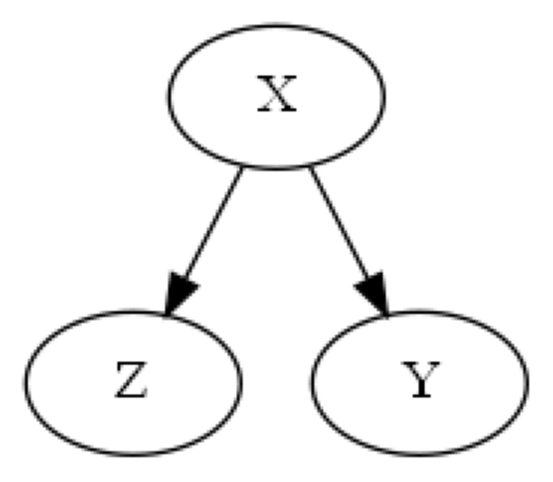

Figure 1(b):


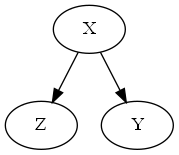

In [4]:
# Random data
treatment = "X"
outcome = "Y"
variables = ["Z"]
causal_graph = "digraph{Z;X;Y; X->Z;X->Y}"
columns = list(treatment) + list(outcome) + list(variables)
df = pd.DataFrame(columns=columns)

# Causal Model Initialization
causal_model = CausalModel(df, treatment, outcome, graph=causal_graph)

# View graph
causal_model.view_model()
print("Figure 1(b):")
display(Image(filename="causal_model.png"))

The backdoor criterion requires the adjustment set **Z** contain no descendents of the treatment set **X**, so the set {Z} clearly does not meet the backdoor criterion. However, {Z} is a valid adjustment set since

$$P(\mathbf{y}|do(\mathbf{x})) = \sum_z P(\mathbf{y}|\mathbf{x},z)P(z).$$

In this example, the empty set is a valid backdoor set though, so the backdoor criterion still identifies a valid adjustment set. Next, we will use an example from Perković et al. (2018) which illustrates a case when the backdoor criterion is unable to identify any adjustment sets, and then we will  use DoWhy's implementation of the generalized adjustment criterion to identify an adjustment set instead. 

## Example 8, Perković et al. (2018)

DoWhy uses the approach laid out in Perković et al. (2018) Definition 4 + Theorem 7, which gives a generalized adjustment criterion. Consider the following graph given in Example 8 of the paper.

C:\Users\paren\Projects\dowhy\dowhy\causal_model.py:583: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


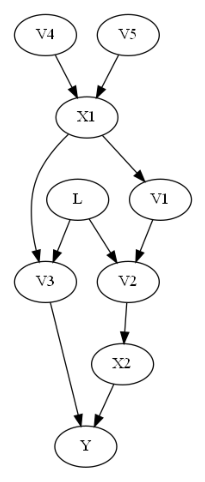

Graph with no backdoor set:


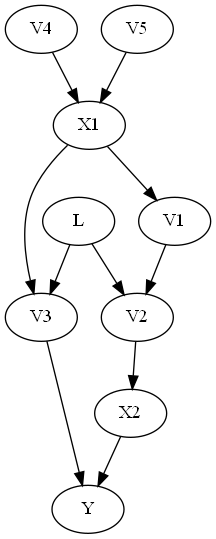

In [6]:
# Random data
treatment = ["X1", "X2"]
outcome = "Y"
variables = ["V1", "V2", "V3", "V4", "V5"]
hidden_variables = ["L"]
causal_graph = """graph[directed 1 node[id "X1" label "X1"]
                node[id "X2" label "X2"]
                node[id "Y" label "Y"]
                node[id "V1" label "V1"]
                node[id "V2" label "V2"]
                node[id "V3" label "V3"]
                node[id "V4" label "V4"]
                node[id "V5" label "V5"]
                node[id "L" label "L"]
                edge[source "V5" target "X1"]
                edge[source "V4" target "X1"]
                edge[source "X1" target "V1"]
                edge[source "V1" target "V2"]
                edge[source "V2" target "X2"]
                edge[source "X2" target "Y"]
                edge[source "X1" target "V3"]
                edge[source "V3" target "Y"]
                edge[source "L" target "V3"]
                edge[source "L" target "V2"]]
                """
columns = list(treatment) + list(outcome) + list(variables)
df = pd.DataFrame(columns=columns)

# Causal Model Initialization
causal_model = CausalModel(df, treatment, outcome, graph=causal_graph)

# View graph
causal_model.view_model()
from IPython.display import Image, display
print("Graph with no backdoor set:")
display(Image(filename="causal_model.png"))

The backdoor criterion requires the adjustment set **Z** to (1) contain no descendents of **X** and (2) to d-separate all backdoor paths from **X** to **Y**. In this case, in the above graph, the backdoor criterion would require the adjustment set to include L (since V2 and V3 are descendents of **X**). But if L is unobserved, then we cannot control for L, and so the backdoor criterion finds no adjustment sets.

The generalized adjustment criterion given in Perković et al. (2018) however is complete, and is able to identify that in fact {V1, V2} is a valid adjustment set. One can use this adjustment criterion to identify an estimand by using the 'identify_effect()' method in the CausalModel class, which gives a minimal adjustment set which meets the general adjustment criterion.

In [16]:
# Causal Identification
identified_estimand = causal_model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                  -1⎤
 ⎢    d        ⎛    ∂              ⎞  ⎥
E⎢─────────(Y)⋅⎜─────────([X₁  X₂])⎟  ⎥
 ⎣d[V₅  V₄]    ⎝∂[V₅  V₄]          ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{V5,V4})
Estimand assumption 2, Exclusion: If we remove {V5,V4}→{X1,X2}, then ¬({V5,V4}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
    d                
─────────(E[Y|V2,V1])
d[X₁  X₂]            
Estimand assumption 1, Unconfoundedness: If U→{X1,X2} and U→Y then P(Y|X1,X2,V2,V1,U) = P(Y|X1,X2,V2,V1)



**We see here that while the backdoor estimand found no adjustment set, the general_adjustment estimand successfully found the set {V1, V2}!**

## References

1. Ilya Shpitser, Tyler VanderWeele, and James M. Robins. "On the validity of covariate adjustment for estimating causal effects." In *Proceedings of UAI 2010*, pages 527–536, 2010.
2. E. Perković, J. Textor, M. Kalisch, and M. H. Maathuis. "Complete graphical characterization and construction of adjustment sets in Markov equivalence classes of ancestral graphs." *Journal of Machine Learning Research*, vol. 18, no. 220, pp. 1–62, 2018. [Online]. Available: [http://jmlr.org/papers/v18/16-319.html](http://jmlr.org/papers/v18/16-319.html)